# Stock Price Prediction of LBLL

## Import the Required Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
from keras import Sequential
from keras.layers import GRU, LSTM, SimpleRNN,  Dense, Dropout
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

2022-07-30 05:13:12.061456: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-30 05:13:12.061495: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load Data

In [3]:
lbbl_df = pd.read_csv("data/LBBL.csv")
lbbl_df.shape

(1877, 8)

In [4]:
lbbl_df.head()

,S.N.,Date,Total Transactions,Total Traded Shares,Total Traded Amount,Max. Price,Min. Price,Close Price
0,1,2021-12-29,196,37355.0,16232734.3,445.7,427.0,430.2
1,2,2021-12-28,293,55587.0,24245227.0,448.0,422.0,437.0
2,3,2021-12-27,407,86428.0,37957307.7,461.0,427.0,429.9
3,4,2021-12-26,375,79223.0,36089623.0,465.0,446.0,453.0
4,5,2021-12-23,403,74536.0,34006761.4,468.0,441.1,451.0


## Renaming the Columns 

In [5]:
lbbl_df.columns = ['SN', 'Date', 'TTrans', 'TTS','TTA', 'MaxPrice', 'MinPrice', 'ClosePrice']

In [6]:
lbbl_df.head()

,SN,Date,TTrans,TTS,TTA,MaxPrice,MinPrice,ClosePrice
0,1,2021-12-29,196,37355.0,16232734.3,445.7,427.0,430.2
1,2,2021-12-28,293,55587.0,24245227.0,448.0,422.0,437.0
2,3,2021-12-27,407,86428.0,37957307.7,461.0,427.0,429.9
3,4,2021-12-26,375,79223.0,36089623.0,465.0,446.0,453.0
4,5,2021-12-23,403,74536.0,34006761.4,468.0,441.1,451.0


In [7]:
lbbl_df.shape

(1877, 8)

Converting the Date into Panda's Date Time 

In [8]:
lbbl_df['Date'] = pd.to_datetime(lbbl_df['Date'])

## Sorting the Date by Date in Ascending Order

In [9]:
lbbl_df=lbbl_df.sort_values(by='Date')

## Setting Features and Target Column

In [10]:
features = ['Date','ClosePrice']

In [11]:
X = lbbl_df[features]

In [12]:
X.set_index("Date",inplace=True)

## Splitting the Data Into Training, Validation and Test Set

In [13]:
X_train_split, X_test_split = train_test_split(X, train_size=0.8,shuffle=False)
X_test_split, X_valid_split = train_test_split(X_test_split, train_size=0.5,shuffle=False)

## Fucntion to slice data to Predict next day’s closing price by looking into previous 5 day’s data

In [14]:
def SliceData(data,step):     
    X,Y = [],[]
    for i in range(len(data)-step):
        X.append(data[i:(i+step),])
        Y.append(data[(i+step),])
    return np.array(X),np.array(Y)

## Normalizing the Data Using Standard Scalar

In [15]:
std_scalar = StandardScaler()
X_train = std_scalar.fit_transform(X_train_split)
X_valid = std_scalar.fit_transform(X_valid_split)
X_test = std_scalar.fit_transform(X_test_split)

## Getting the Sliced Data

In [16]:
steps = 5
X_train,y_train = SliceData(X_train,steps)
X_test,y_test = SliceData(X_test,steps)
X_valid,y_valid = SliceData(X_valid,steps)

## Building the RNN Model

In [17]:
RNN_Model = Sequential()
RNN_Model.add(SimpleRNN(50,input_shape=(steps,1),return_sequences=True ))
RNN_Model.add(Dropout(0.5))
RNN_Model.add(SimpleRNN(50))
RNN_Model.add(Dropout(0.5))
RNN_Model.add(Dense(50))
RNN_Model.compile(optimizer='adam',loss='mean_squared_error', metrics=['mae'])

2022-07-30 05:13:14.661463: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-30 05:13:14.661532: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-30 05:13:14.661565: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xenon-Inspiron-3442): /proc/driver/nvidia/version does not exist
2022-07-30 05:13:14.661966: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
RNN_Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 5, 50)             2600      
                                                                 
 dropout (Dropout)           (None, 5, 50)             0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
Total params: 10,200
Trainable params: 10,200
Non-trainable params: 0
_________________________________________________________________


## Building LSTM Model

In [19]:
LSTM_Model = Sequential()
LSTM_Model.add(LSTM(50,input_shape=(steps,1),return_sequences=True ))
LSTM_Model.add(Dropout(0.5))
LSTM_Model.add(LSTM(50))
LSTM_Model.add(Dropout(0.5))
LSTM_Model.add(Dense(50))
LSTM_Model.compile(optimizer='adam',loss='mean_squared_error', metrics=['mae'])

In [20]:
LSTM_Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             10400     
                                                                 
 dropout_2 (Dropout)         (None, 5, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
Total params: 33,150
Trainable params: 33,150
Non-trainable params: 0
_________________________________________________________________


## Fitting the RNN Model

In [21]:
RNN_History = RNN_Model.fit(X_train,y_train,epochs=100,batch_size = 50,validation_data=(X_valid,y_valid),shuffle=False, 
                    verbose = 2)

Epoch 1/100
30/30 - 3s - loss: 1.0524 - mae: 0.6914 - val_loss: 0.3640 - val_mae: 0.4768 - 3s/epoch - 86ms/step
Epoch 2/100
30/30 - 0s - loss: 0.6069 - mae: 0.5161 - val_loss: 0.2064 - val_mae: 0.3568 - 179ms/epoch - 6ms/step
Epoch 3/100
30/30 - 0s - loss: 0.4353 - mae: 0.4373 - val_loss: 0.1949 - val_mae: 0.3505 - 177ms/epoch - 6ms/step
Epoch 4/100
30/30 - 0s - loss: 0.3702 - mae: 0.4073 - val_loss: 0.1735 - val_mae: 0.3328 - 169ms/epoch - 6ms/step
Epoch 5/100
30/30 - 0s - loss: 0.3258 - mae: 0.3792 - val_loss: 0.1375 - val_mae: 0.2954 - 171ms/epoch - 6ms/step
Epoch 6/100
30/30 - 0s - loss: 0.2902 - mae: 0.3597 - val_loss: 0.1453 - val_mae: 0.3037 - 171ms/epoch - 6ms/step
Epoch 7/100
30/30 - 0s - loss: 0.2701 - mae: 0.3388 - val_loss: 0.1040 - val_mae: 0.2553 - 165ms/epoch - 5ms/step
Epoch 8/100
30/30 - 0s - loss: 0.2334 - mae: 0.3168 - val_loss: 0.0894 - val_mae: 0.2379 - 170ms/epoch - 6ms/step
Epoch 9/100
30/30 - 0s - loss: 0.1983 - mae: 0.2946 - val_loss: 0.0790 - val_mae: 0.2253 -

Epoch 73/100
30/30 - 0s - loss: 0.0658 - mae: 0.1647 - val_loss: 0.0413 - val_mae: 0.1652 - 160ms/epoch - 5ms/step
Epoch 74/100
30/30 - 0s - loss: 0.0649 - mae: 0.1702 - val_loss: 0.0437 - val_mae: 0.1698 - 156ms/epoch - 5ms/step
Epoch 75/100
30/30 - 0s - loss: 0.0614 - mae: 0.1625 - val_loss: 0.0469 - val_mae: 0.1756 - 157ms/epoch - 5ms/step
Epoch 76/100
30/30 - 0s - loss: 0.0664 - mae: 0.1696 - val_loss: 0.0455 - val_mae: 0.1739 - 175ms/epoch - 6ms/step
Epoch 77/100
30/30 - 0s - loss: 0.0612 - mae: 0.1652 - val_loss: 0.0463 - val_mae: 0.1744 - 175ms/epoch - 6ms/step
Epoch 78/100
30/30 - 0s - loss: 0.0634 - mae: 0.1696 - val_loss: 0.0499 - val_mae: 0.1822 - 168ms/epoch - 6ms/step
Epoch 79/100
30/30 - 0s - loss: 0.0652 - mae: 0.1724 - val_loss: 0.0543 - val_mae: 0.1909 - 335ms/epoch - 11ms/step
Epoch 80/100
30/30 - 0s - loss: 0.0658 - mae: 0.1750 - val_loss: 0.0566 - val_mae: 0.1932 - 177ms/epoch - 6ms/step
Epoch 81/100
30/30 - 0s - loss: 0.0704 - mae: 0.1727 - val_loss: 0.0504 - val_m

In [22]:
LSTM_History = LSTM_Model.fit(X_train,y_train,epochs=100,batch_size = 50,validation_data=(X_valid,y_valid),shuffle=False, 
                    verbose = 2)

Epoch 1/100
30/30 - 6s - loss: 0.9566 - mae: 0.7277 - val_loss: 0.7364 - val_mae: 0.7396 - 6s/epoch - 190ms/step
Epoch 2/100
30/30 - 0s - loss: 0.6934 - mae: 0.5664 - val_loss: 0.2728 - val_mae: 0.4135 - 283ms/epoch - 9ms/step
Epoch 3/100
30/30 - 0s - loss: 0.3847 - mae: 0.4055 - val_loss: 0.1676 - val_mae: 0.3280 - 358ms/epoch - 12ms/step
Epoch 4/100
30/30 - 0s - loss: 0.2639 - mae: 0.3316 - val_loss: 0.1400 - val_mae: 0.2979 - 388ms/epoch - 13ms/step
Epoch 5/100
30/30 - 0s - loss: 0.2232 - mae: 0.3083 - val_loss: 0.1230 - val_mae: 0.2776 - 316ms/epoch - 11ms/step
Epoch 6/100
30/30 - 0s - loss: 0.1844 - mae: 0.2795 - val_loss: 0.1167 - val_mae: 0.2708 - 286ms/epoch - 10ms/step
Epoch 7/100
30/30 - 0s - loss: 0.1689 - mae: 0.2736 - val_loss: 0.1097 - val_mae: 0.2606 - 295ms/epoch - 10ms/step
Epoch 8/100
30/30 - 0s - loss: 0.1600 - mae: 0.2655 - val_loss: 0.0981 - val_mae: 0.2445 - 343ms/epoch - 11ms/step
Epoch 9/100
30/30 - 0s - loss: 0.1365 - mae: 0.2443 - val_loss: 0.0934 - val_mae: 0

Epoch 72/100
30/30 - 0s - loss: 0.0582 - mae: 0.1548 - val_loss: 0.0437 - val_mae: 0.1581 - 307ms/epoch - 10ms/step
Epoch 73/100
30/30 - 0s - loss: 0.0552 - mae: 0.1534 - val_loss: 0.0450 - val_mae: 0.1699 - 309ms/epoch - 10ms/step
Epoch 74/100
30/30 - 0s - loss: 0.0581 - mae: 0.1592 - val_loss: 0.0389 - val_mae: 0.1420 - 300ms/epoch - 10ms/step
Epoch 75/100
30/30 - 0s - loss: 0.0639 - mae: 0.1682 - val_loss: 0.0675 - val_mae: 0.2102 - 301ms/epoch - 10ms/step
Epoch 76/100
30/30 - 0s - loss: 0.0706 - mae: 0.1816 - val_loss: 0.0454 - val_mae: 0.1586 - 308ms/epoch - 10ms/step
Epoch 77/100
30/30 - 0s - loss: 0.0573 - mae: 0.1554 - val_loss: 0.0424 - val_mae: 0.1639 - 298ms/epoch - 10ms/step
Epoch 78/100
30/30 - 0s - loss: 0.0660 - mae: 0.1671 - val_loss: 0.0702 - val_mae: 0.2094 - 301ms/epoch - 10ms/step
Epoch 79/100
30/30 - 0s - loss: 0.0727 - mae: 0.1822 - val_loss: 0.0895 - val_mae: 0.2323 - 294ms/epoch - 10ms/step
Epoch 80/100
30/30 - 0s - loss: 0.0924 - mae: 0.2171 - val_loss: 0.0537 

## Make Predictions

In [23]:
RNN_Predictions = RNN_Model.predict(X_test)
LSTM_predictions = LSTM_Model.predict(X_test)

## Inverse Transform the Values

In [24]:
RNN_act_prd = std_scalar.inverse_transform(RNN_Predictions)
LSTM_act_prd = std_scalar.inverse_transform(LSTM_predictions)

## Evalation Metrics (RMSE and MAE)

In [25]:
print("### RNN Model ###")
Y_test_res_RNN = std_scalar.inverse_transform(y_test)
pre_RNN = RNN_act_prd[:,:1]

rmse=np.sqrt(np.mean(((pre_RNN- Y_test_res_RNN)**2)))
print(f"RMSE {rmse}"  )

print(f"MAE {mean_absolute_error(Y_test_res_RNN, pre_RNN)}")

### RNN Model ###
RMSE 6.4697278074282405
MAE 5.187774324677681


In [26]:
print("### LSTM Model ###")
Y_test_res_LSTM = std_scalar.inverse_transform(y_test)
pre_LSTM = LSTM_act_prd[:,:1]

rmse=np.sqrt(np.mean(((pre_LSTM- Y_test_res_LSTM)**2)))
print(f"RMSE {rmse}"  )

print(f"MAE {mean_absolute_error(Y_test_res_LSTM, pre_LSTM)}")

### LSTM Model ###
RMSE 5.652457303598954
MAE 3.958984041474556


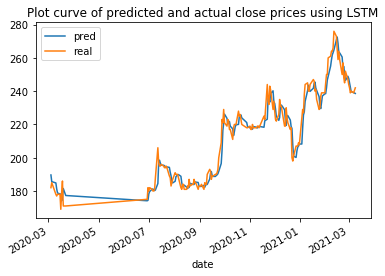

In [27]:
plot =pd.DataFrame()
plot["pred"]=list(map(float, pre_LSTM))
plot["real"]=list(map(float, Y_test_res_LSTM))
plot["date"]=X_test_split.index[:-steps]
plot.plot(kind="line", x="date", title="Plot curve of predicted and actual close prices using LSTM")
plt.show()

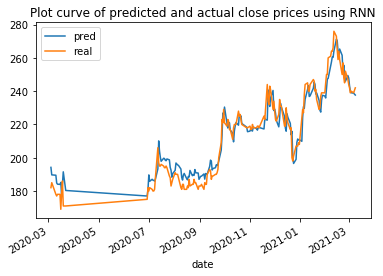

In [28]:
plot =pd.DataFrame()
plot["pred"]=list(map(float, pre_RNN))
plot["real"]=list(map(float, Y_test_res_RNN))
plot["date"]=X_test_split.index[:-steps]
plot.plot(kind="line", x="date", title="Plot curve of predicted and actual close prices using RNN")
plt.show()

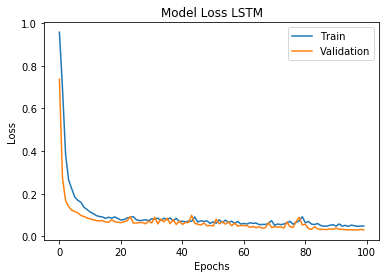

In [29]:
plt.plot(LSTM_History.history['loss'])
plt.plot(LSTM_History.history['val_loss'])
plt.title('Model Loss LSTM')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

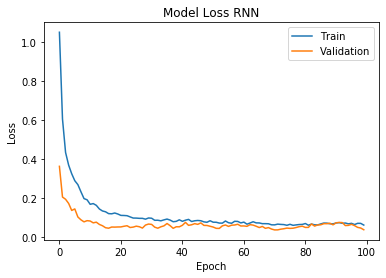

In [30]:
plt.plot(RNN_History.history['loss'])
plt.plot(RNN_History.history['val_loss'])
plt.title('Model Loss RNN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

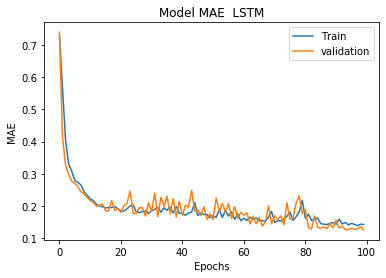

In [31]:
plt.plot(LSTM_History.history['mae'])
plt.plot(LSTM_History.history['val_mae'])
plt.title('Model MAE  LSTM')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.legend(['Train', 'validation'], loc='upper right')
plt.show()

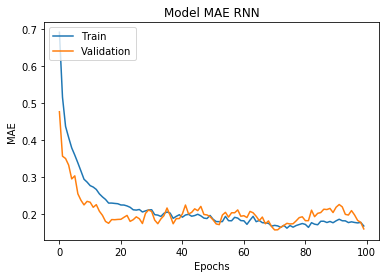

In [32]:
plt.plot(RNN_History.history['mae'])
plt.plot(RNN_History.history['val_mae'])
plt.title('Model MAE RNN')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Conclusion

1. For LBBL Bank LSTM and RNN Models used for Stock Price Prediction
2. The Error is Low for LSTM Model